In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score
pd.set_option('display.max_columns', None)

In [191]:
outliers_data_x = pd.read_csv("C:\\Users\\realn\\PycharmProjects\\MFDP\\tuning\\2_best_features_permutation.csv")
outliers_data_y = pd.read_csv("C:\\Users\\realn\\PycharmProjects\\MFDP\\tuning\\1_outliers_raw_data.csv")["TARGET"]

In [192]:
X = outliers_data_x
y = outliers_data_y
train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)

In [5]:
import joblib
gbm_pickle = joblib.load('C:\\Users\\realn\\PycharmProjects\\MFDP\\app\\artifacts\\lgb.pkl')
y_test_pred_dr = gbm_pickle.predict_proba(test_X_cv)

In [7]:
fpr, tpr, thresholds = metrics.roc_curve(test_y_cv, y_test_pred_dr[:,1])

## Расчёт оптимального threshold
Оптимальным считается такой threshold, что argmax(tpr - fpr)
Тем не менее, в нашеё задаче это неизбежно приведёт к росту FN класса

Threshold value is: 0.06972404738053123


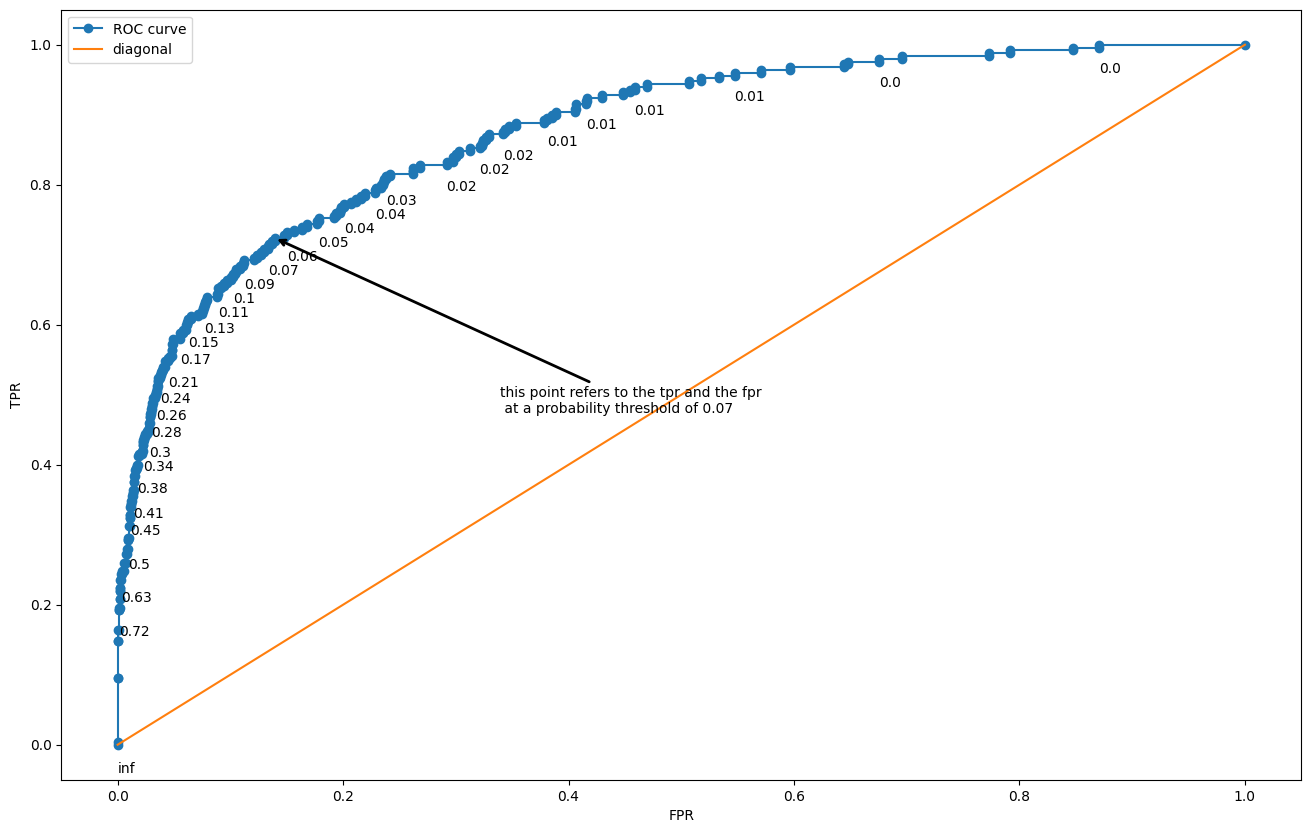

In [25]:
def plot_roc_curve(fpr, tpr, rnd_idx = 27):
    plt.subplots(figsize=(16, 10))
    plt.plot(fpr, tpr, 'o-', label="ROC curve")
    plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
    for x, y, txt in zip(fpr[::10], tpr[::10], thresholds[::10]):
        plt.annotate(np.round(txt,2), (x, y-0.04))

    plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 3)), 
                 xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
                 arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
    plt.legend(loc="upper left")
    plt.xlabel("FPR")
    plt.ylabel("TPR")

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

## FN с оптимальным threshold


250


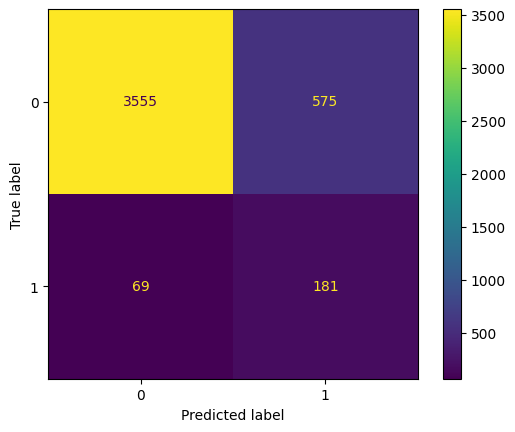

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(test_y_cv.sum())
rounded_predicts = (gbm_pickle.predict_proba(test_X_cv)[:,1] >= optimal_threshold).astype(bool)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y_cv, rounded_predicts, labels=[0, 1])).plot()

Попробуем интервальный метод. Он заключается в том, чтобы посчитать, скольким людям выдали кредиты в каких интервалах скора, и какая оказалась в этих вариантах итоговая конверсия таргета (выдано-возвращено). В таком случае, имея эти интервальные значения, можно указать формулу, которая бы рассчитывала потенциальные убытки от невозврата кредитов, выданных аппликанту, находящемуся в таком интервале.



In [206]:
data = pd.DataFrame(test_y_cv)
data["predict"] = gbm_pickle.predict_proba(test_X_cv)[:,1]
data

,TARGET,predict
7267,0,0.051478
17958,0,0.007258
17521,1,0.152929
11766,0,0.103103
640,0,0.001307
...,...,...
2045,0,0.003915
9734,0,0.009572
20139,1,0.806311
19311,0,0.001926


In [64]:
# Равномерные интервалы

credits_overall = len(data.loc[(data['predict'] >= 0.9) & (data['predict'] < 1.0)])
credits_defaulted = data.loc[(data['predict'] >= 0.9) & (data['predict'] < 1.0)]['TARGET'].sum()
conversion  = (credits_overall - credits_defaulted)/credits_overall
print(credits_overall, credits_defaulted, conversion)

24 24 0.0


In [207]:
l_ = 0.0
r_ = 0.1
conversion = pd.DataFrame()
while r_ < 1:
    credits_overall = len(data.loc[(data['predict'] >= l_) & (data['predict'] < r_)])
    credits_defaulted = data.loc[(data['predict'] >= l_) & (data['predict'] < r_)]['TARGET'].sum()
    conversion = conversion.append({
        "conversion":(credits_overall - credits_defaulted)/credits_overall , 
        "interval":(str(round(l_, 1)) + "-" + str(round(r_,1))),
        "right_border": (round(r_,1)),
        "credits_overall": credits_overall
                                   }, ignore_index=True)
        
    l_+=0.1
    r_+=0.1

conversion

,conversion,interval,right_border,credits_overall
0,0.978100,0.0-0.1,0.1,3790
1,0.888462,0.1-0.2,0.2,260
2,0.754717,0.2-0.3,0.3,106
3,0.753846,0.3-0.4,0.4,65
4,0.521739,0.4-0.5,0.5,46
5,0.647059,0.5-0.6,0.6,34
6,0.454545,0.6-0.7,0.7,22
7,0.285714,0.7-0.8,0.8,14
8,0.157895,0.8-0.9,0.9,19
9,0.000000,0.9-1.0,1.0,24


In [216]:
# Допустим, кредит стоит 12 000 000
credit_applied = 12000000

# Допустим, мы попали в интервал номер:
interval = 7

# Мы выдаём всем на интервал одинаковое количество кредитов одинаковой суммы
credit_applied = credit_applied * conversion["credits_overall"][interval]

# Тогда мат.ожидание продукта:
credit_mo = credit_applied * conversion["conversion"][interval]

# Тогда наша прибыльт будет определяться ставкой. Поставим 20% годовых и срок - 10 лет
years = 10
percent = 0.25
credit_with_percent = credit_mo * percent * years

# итоговая прибыль
profit = credit_mo + credit_with_percent - credit_applied

# прибыль на один кредит
profit = profit/conversion["credits_overall"][interval]

profit

0.0

### Вывод
При 25% ставке не выгодновыдавать кредиты с трешхолдом в интервале 0.7 - 0.8. Это существенно большие границы клиентской базы, нежели оптимальный трешхолд.
Давайте попробуем равномощные интервалы?

In [217]:
interval_count = 100
data["qcut"] = pd.qcut(data["predict"], interval_count)
data

,TARGET,predict,qcut
7267,0,0.051478,"(0.0507, 0.0548]"
17958,0,0.007258,"(0.00705, 0.0074]"
17521,1,0.152929,"(0.144, 0.161]"
11766,0,0.103103,"(0.0955, 0.106]"
640,0,0.001307,"(0.00123, 0.00133]"
...,...,...,...
2045,0,0.003915,"(0.00373, 0.00393]"
9734,0,0.009572,"(0.00935, 0.00971]"
20139,1,0.806311,"(0.789, 0.995]"
19311,0,0.001926,"(0.00183, 0.00195]"


In [238]:
interval_tuples = pd.qcut(data["predict"], interval_count ).cat.categories.to_tuples()

ind = 0

l_ = interval_tuples[ind][0]
r_ = interval_tuples[ind][1]
conversion_w = pd.DataFrame()
while ind <= interval_count - 1:
    credits_overall = len(data.loc[(data['predict'] >= l_) & (data['predict'] < r_)])
    credits_defaulted = data.loc[(data['predict'] >= l_) & (data['predict'] < r_)]['TARGET'].sum()
    conversion_w = conversion_w.append({
        "conversion":(credits_overall - credits_defaulted)/credits_overall , 
        "interval":(str(round(l_, 4)) + "-" + str(round(r_,4))),
        "right_border": (round(r_,4)),
        "credits_overall": credits_overall
                                   }, ignore_index=True)


    ind += 1
    if ind == interval_count :
        break
    l_ = interval_tuples[ind][0]
    r_ = interval_tuples[ind][1]
    

conversion_w

,conversion,interval,right_border,credits_overall
0,1.000000,-0.001-0.0002,0.0002,44
1,1.000000,0.0002-0.0003,0.0003,44
2,1.000000,0.0003-0.0004,0.0004,44
3,1.000000,0.0004-0.0005,0.0005,42
4,1.000000,0.0005-0.0006,0.0006,45
...,...,...,...,...
95,0.790698,0.308-0.375,0.3750,43
96,0.590909,0.375-0.445,0.4450,44
97,0.545455,0.445-0.578,0.5780,44
98,0.454545,0.578-0.789,0.7890,44


In [239]:
# Допустим, кредит стоит 12 000 000
credit_applied = 12000000

# Допустим, мы попали в интервал номер:
interval = 98

# Мы выдаём всем на интервал одинаковое количество кредитов одинаковой суммы
credit_applied = credit_applied * conversion_w["credits_overall"][interval]

# Тогда мат.ожидание продукта:
credit_mo = credit_applied * conversion_w["conversion"][interval]

# Тогда наша прибыльт будет определяться ставкой. Поставим 20% годовых
years = 10
percent = 0.25
credit_with_percent = credit_mo * percent * years

# итоговая прибыль
profit = credit_mo + credit_with_percent - credit_applied

# прибыль на один кредит
profit = profit/conversion_w["credits_overall"][interval]

print(profit, conversion_w["interval"][interval])

7090909.090909091 0.578-0.789


### Вывод
Равномощные интервалы позволяют уточнить точку безубыточности до максимального предела. Например - 0.578-0.789 при сумме кредита в 12 000 000 и процентной ставке 25%
А как обстоят дела с реальными суммами?

In [226]:
outliers_data_x_ = pd.read_csv("C:\\Users\\realn\\PycharmProjects\\MFDP\\tuning\\1_outliers_raw_data.csv")


X_ = outliers_data_x_.drop(columns=["TARGET"])
y = outliers_data_x_["TARGET"]
train_XX_cv, test_XX_cv, train_y_cv, test_y_cv = train_test_split(X_, y, train_size=0.8, random_state=42)

In [227]:
data = pd.DataFrame(test_y_cv)
data["predict"] = gbm_pickle.predict_proba(test_X_cv)[:,1]
data["AMOUNT"] = test_XX_cv["AMT_CREDIT"]

In [228]:
interval_count = 100
data["qcut"] = pd.qcut(data["predict"], interval_count)
data

,TARGET,predict,AMOUNT,qcut
7267,0,0.051478,1288350.0,"(0.0507, 0.0548]"
17958,0,0.007258,1288350.0,"(0.00705, 0.0074]"
17521,1,0.152929,1256400.0,"(0.144, 0.161]"
11766,0,0.103103,1345036.5,"(0.0955, 0.106]"
640,0,0.001307,1800000.0,"(0.00123, 0.00133]"
...,...,...,...,...
2045,0,0.003915,1305000.0,"(0.00373, 0.00393]"
9734,0,0.009572,2025000.0,"(0.00935, 0.00971]"
20139,1,0.806311,1762110.0,"(0.789, 0.995]"
19311,0,0.001926,1546020.0,"(0.00183, 0.00195]"


In [229]:
interval_tuples = pd.qcut(data["predict"], interval_count ).cat.categories.to_tuples()

ind = 0

l_ = interval_tuples[ind][0]
r_ = interval_tuples[ind][1]
conversion_w = pd.DataFrame()
while ind <= interval_count - 1:
    credits_overall = len(data.loc[(data['predict'] >= l_) & (data['predict'] < r_)])
    credits_defaulted = data.loc[(data['predict'] >= l_) & (data['predict'] < r_)]['TARGET'].sum()
    credit_applied = data.loc[(data['predict'] >= l_) & (data['predict'] < r_)]['AMOUNT'].sum()
    conversion_w = conversion_w.append({
        "conversion":(credits_overall - credits_defaulted)/credits_overall , 
        "interval":(str(round(l_, 4)) + "-" + str(round(r_,4))),
        "right_border": (round(r_,4)),
        "credits_overall": credits_overall,
        "credit_applied": credit_applied
                                   }, ignore_index=True)
        

    ind += 1
    if ind == interval_count :
        break
    l_ = interval_tuples[ind][0]
    r_ = interval_tuples[ind][1]
    

conversion_w

,conversion,interval,right_border,credits_overall,credit_applied
0,1.000000,-0.001-0.0002,0.0002,44,63238531.5
1,1.000000,0.0002-0.0003,0.0003,44,65625210.0
2,1.000000,0.0003-0.0004,0.0004,44,67009698.0
3,1.000000,0.0004-0.0005,0.0005,42,65201562.0
4,1.000000,0.0005-0.0006,0.0006,45,68219271.0
...,...,...,...,...,...
95,0.790698,0.308-0.375,0.3750,43,62957034.0
96,0.590909,0.375-0.445,0.4450,44,64899616.5
97,0.545455,0.445-0.578,0.5780,44,63076288.5
98,0.454545,0.578-0.789,0.7890,44,65725749.0


In [233]:
# Допустим, мы попали в интервал номер:
interval = 98

# Мы выдаём всем на интервал одинаковое количество кредитов одинаковой суммы
credit_applied = conversion_w["credit_applied"][interval] * conversion_w["credits_overall"][interval]

# Тогда мат.ожидание продукта:
credit_mo = credit_applied * conversion_w["conversion"][interval]

# Тогда наша прибыльт будет определяться ставкой. Поставим 20% годовых
years = 10
percent = 0.25
credit_with_percent = credit_mo * percent * years

# итоговая прибыль
profit = credit_mo + credit_with_percent - credit_applied

# прибыль на один кредит
profit = profit/conversion_w["credits_overall"][interval]

print(profit, conversion_w["interval"][interval])

38837942.59090909 0.578-0.789


## Вывод

Равномощные интервалы позволяют уточнить точку безубыточности до максимального предела. Например - 0.578-0.789 при процентной ставке 25% даже для оригинальных сумм запроса.
Теперь спроектируем работу калькулятора.

In [241]:
conversion_w.to_csv("conversion_intervals.csv", index=False)

In [253]:
# Загрузка данных
intervals = pd.read_csv("conversion_intervals.csv")

# инциация данных
prediction = 0.11

# расчёт интервала
pred_interval = len(intervals[intervals["right_border"]<prediction])-1

# инициируем светофочик

int_color = ""

if (intervals["conversion"][pred_interval] > 0.98):
    int_color = "green"

elif (intervals["conversion"][pred_interval] <= 0.98) & (intervals["conversion"][pred_interval] > 0.9):
    int_color = "yellow"

else:
    int_color = "red"

# инициируем расчёт калькулятора

# Мы выдаём всем на интервал одинаковое количество кредитов одинаковой суммы
credit_sum =12000000
credit_applied = credit_sum * intervals["credits_overall"][pred_interval]

# Тогда мат.ожидание продукта:
credit_mo = credit_applied * intervals["conversion"][pred_interval]

# инциация данных
years = 10
percent = 0.25
credit_with_percent = credit_mo * percent * years

# итоговая прибыль
profit = credit_mo + credit_with_percent - credit_applied

# прибыль на один кредит
profit = profit/intervals["credits_overall"][pred_interval]

print(profit, intervals["interval"][pred_interval], int_color)

26500000.0 0.0955-0.106 yellow
